# NSL Notebook 12

In [1]:
from default import *

## Keras - Deep & Convolutional NN image recognition

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [2]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


an example of a data point with label 4
an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


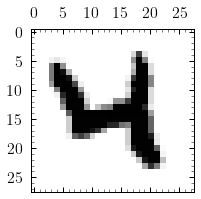

In [3]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
fig, ax = plt.subplots(figsize=(3,3));
ax.matshow(X_train[20,:].reshape(28,28),cmap='binary');

print('an example of a data point with label', Y_train[20], 'before to_categorical ...')
# convert class vectors to binary class matrices, 
# e.g. for use with categorical_crossentropy
Y_train = utils.to_categorical(Y_train, num_classes)
Y_test = utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Example: to_categorical

In [4]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns 
# as there are classes. The number of rows stays the same.
utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [4]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [7]:
def compile_model():
    # create the model
    model = create_DNN()
    # compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [8]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7662 - accuracy: 0.7753 - val_loss: 0.3162 - val_accuracy: 0.9150
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3886 - accuracy: 0.8880 - val_loss: 0.2428 - val_accuracy: 0.9318
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3163 - accuracy: 0.9103 - val_loss: 0.2017 - val_accuracy: 0.9422
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2708 - accuracy: 0.9226 - val_loss: 0.1770 - val_accuracy: 0.9473
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2376 - accuracy: 0.9322 - val_loss: 0.1587 - val_accuracy: 0.9522


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

In [9]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.1587 - accuracy: 0.9522

Test loss: 0.15871307253837585
Test accuracy: 0.9521999955177307


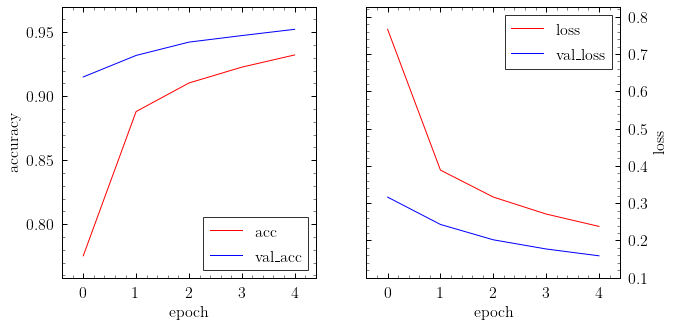

In [20]:
# look into training history

df = pd.DataFrame(history.history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5));

df['accuracy'].plot.line(c='r', label='acc', ax=ax1);
df['val_accuracy'].plot.line(c='b', label='val\_acc', ax=ax1);

df['loss'].plot.line(c='r', label='loss', ax=ax2);
df['val_loss'].plot.line(c='b', label='val\_loss', ax=ax2);

ax1.legend()
ax2.legend()

ax1.set_xlabel('epoch');
ax1.set_ylabel('accuracy');

ax2.set_xlabel('epoch');
ax2.set_ylabel('loss');
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')
ax2.yaxis.set_label_position("right")

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

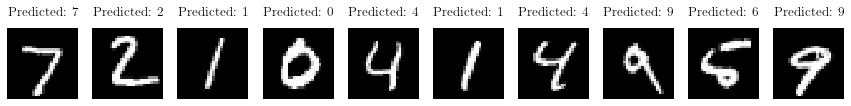

In [40]:
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title(f"Predicted: {np.argmax(predictions[i])}", fontsize='small')   
    plt.axis('off')

### Exercise 12.1

By keeping fixed all the other parameters, try to use at least two other optimizers, different from SGD. <span style="color:red">Watch to accuracy and loss for training and validation data and comment on the performances</span>.

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [4]:
# reshape data, depending on Keras backend
if backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

In [5]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


Train your DCNN and evaluate its performance proceeding exactly as before:

In [6]:
# training parameters
batch_size = 32
epochs = 5

# create the deep conv net
model_CNN = create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
                        batch_size=batch_size, 
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, Y_test))

Epoch 1/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1921 - accuracy: 0.9429 - val_loss: 0.0739 - val_accuracy: 0.9762
Epoch 2/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0776 - accuracy: 0.9762 - val_loss: 0.0471 - val_accuracy: 0.9840
Epoch 3/5
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0571 - accuracy: 0.9817 - val_loss: 0.0401 - val_accuracy: 0.9861
Epoch 4/5
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0427 - accuracy: 0.9864 - val_loss: 0.0414 - val_accuracy: 0.9863
Epoch 5/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0367 - accuracy: 0.9878 - val_loss: 0.0374 - val_accuracy: 0.9875


In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

In [7]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.0374 - accuracy: 0.9875

Test loss: 0.03740076348185539
Test accuracy: 0.987500011920929


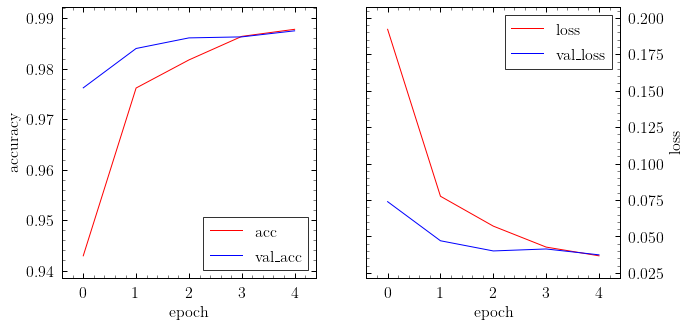

In [8]:
# look into training history

df = pd.DataFrame(history.history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5));

df['accuracy'].plot.line(c='r', label='acc', ax=ax1);
df['val_accuracy'].plot.line(c='b', label='val\_acc', ax=ax1);

df['loss'].plot.line(c='r', label='loss', ax=ax2);
df['val_loss'].plot.line(c='b', label='val\_loss', ax=ax2);

ax1.legend()
ax2.legend()

ax1.set_xlabel('epoch');
ax1.set_ylabel('accuracy');

ax2.set_xlabel('epoch');
ax2.set_ylabel('loss');
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')
ax2.yaxis.set_label_position("right")

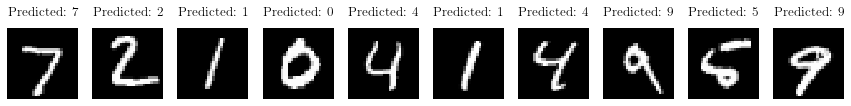

In [10]:
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title(f"Predicted: {np.argmax(predictions[i])}", fontsize='small')   
    plt.axis('off')

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

Loading `gimp` hand-written digits ...

In [42]:
from digits import *

Plot them and predict digits using CNN ...

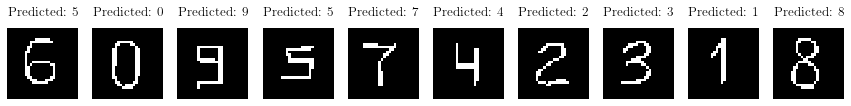

In [43]:
plt.figure(figsize=(15, 15)) 
for i, digit in enumerate(gimp_digits):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(digit, cmap='gray')
    xdim, ydim = digit.shape
    prediction = model_CNN.predict(digit.reshape(1, xdim, ydim, 1))
    plt.title(f"Predicted: {np.argmax(prediction)}", fontsize='small')   
    plt.axis('off')